<a href="https://colab.research.google.com/github/Untick/IrisID_gr2/blob/Artem-Morozov-folder/Artem%20Morozov/%D0%B8%D0%B4%D0%B5%D0%BD%D1%82%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%BF%D0%BE_%D0%B3%D0%BB%D0%B0%D0%B7%D1%83_(Iris).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D, Lambda
from tensorflow.keras.layers import Resizing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from google.colab import drive
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np 
import random
import gc 

In [ ]:
def plot_reault(train_acc, val_acc, train_loss, val_loss):
  
  plt.figure(figsize=(16, 10))
  
  plt.subplot(2, 2, 1)
  plt.title('Точность', fontweight='bold')
  plt.plot(train_acc, label='Точность на обучащей выборке')
  plt.plot(val_acc, label='Точность на проверочной выборке')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()

  plt.subplot(2, 2, 2)
  plt.title('Ошибка', fontweight='bold')
  plt.plot(train_loss, label='Ошибка на обучающей выборке')
  plt.plot(val_loss, label='Ошибка на проверочной выборке')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Ошибка')
  plt.legend()

  plt.show()

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qo '/content/drive/MyDrive/Тест классы.zip' -d /content

In [ ]:
!unzip -qo '/content/drive/MyDrive/Классы — копия.zip' -d /content

['10L', '10R', '1L', '1R', '2L', '2R', '3L', '3R', '4L', '4R', '5L', '5R', '6L', '6R', '7L', '7R', '8L', '8R', '9L', '9R']
пациент 10L


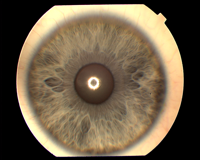

пациент 10R


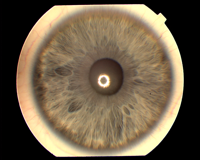

пациент 1L


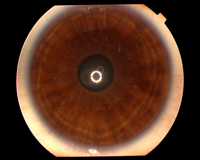

пациент 1R


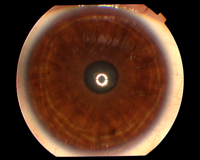

пациент 2L


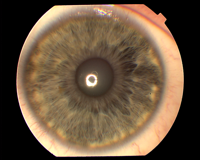

пациент 2R


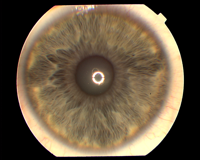

пациент 3L


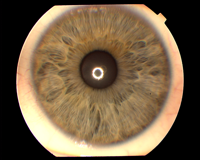

пациент 3R


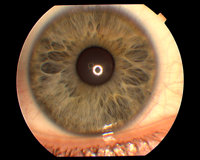

пациент 4L


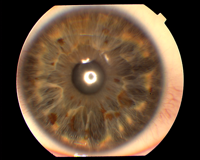

пациент 4R


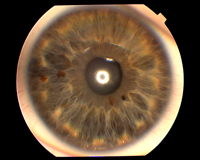

пациент 5L


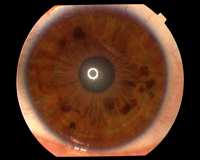

пациент 5R


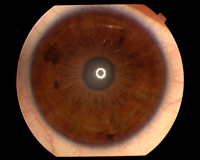

пациент 6L


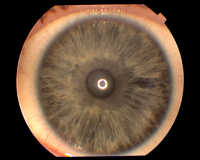

пациент 6R


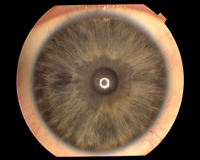

пациент 7L


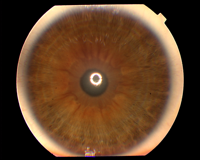

пациент 7R


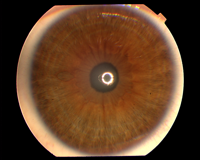

пациент 8L


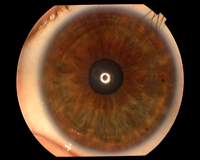

пациент 8R


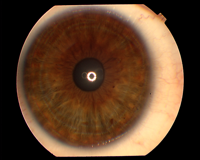

пациент 9L


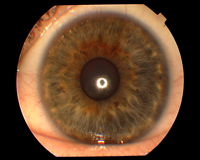

пациент 9R


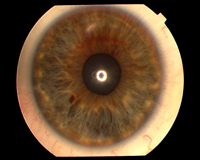

In [ ]:
data_dir = '/content/Классы — копия/'
Classes = os.listdir(data_dir)
Classes.sort()
print(Classes)

for cls in Classes:
    path_class = data_dir + cls    
    img_path = path_class + '/' + os.listdir(path_class)[0]  
    image = Image.open(img_path)
    image = image.resize((200,160))
    print(f'пациент {cls}')
    image.show()

In [ ]:
batch_size = 4
IMG_WIDTH = 200                          
IMG_HEIGHT = 200
Channels = 3

VAL_SPLIT = 0.2
ROTATION_RANGE = 8                     
WIDTH_SHIFT_RANGE = 0.15                  
HEIGHT_SHIFT_RANGE = 0.15                  
ZOOM_RANGE = 0.15                 
BRIGHTNESS_RANGE = (0.7, 1.3)            
HORIZONTAL_FLIP = True   

In [ ]:
datagen = ImageDataGenerator(
    rescale=1. / 255.,
    rotation_range=ROTATION_RANGE,
    width_shift_range=WIDTH_SHIFT_RANGE,
    height_shift_range=HEIGHT_SHIFT_RANGE,
    zoom_range=ZOOM_RANGE,
    brightness_range=BRIGHTNESS_RANGE,
    horizontal_flip=HORIZONTAL_FLIP,
    validation_split=VAL_SPLIT
)

datagen_test = ImageDataGenerator(
    rescale=1. / 255.,    
)

In [ ]:
train_generator = datagen.flow_from_directory(
    data_dir,                            
    target_size=(IMG_WIDTH, IMG_HEIGHT), 
    batch_size=batch_size,              
    class_mode='categorical',                
    shuffle=False,                      
    subset='training'                    
)
val_generator = datagen.flow_from_directory(
    data_dir,                            
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,               
    class_mode='categorical',                  
    shuffle=False,                       
    subset='validation'                  
)
data_dir_test = '/content/Тест классы'
test_generator = datagen_test.flow_from_directory(
    data_dir_test,  
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size = 20,
    class_mode='categorical',
    shuffle=False,          
)

Found 360 images belonging to 20 classes.
Found 80 images belonging to 20 classes.
Found 20 images belonging to 20 classes.


In [ ]:
Class_name = []
for img, labels in train_generator:
    pass
    break
for Keys in train_generator.class_indices.keys():    
    Class_name.append(Keys)
print(Class_name)
print(f'Количество батчей в обучающей выборке {len(train_generator)}') 
print(f'Форма одного батча картинок в обучающей выборке {img.shape, img.dtype}')
print(f'Форма одного батча меток в обучающей выборке {labels.shape, img.dtype}') 

['10L', '10R', '1L', '1R', '2L', '2R', '3L', '3R', '4L', '4R', '5L', '5R', '6L', '6R', '7L', '7R', '8L', '8R', '9L', '9R']
Количество батчей в обучающей выборке 90
Форма одного батча картинок в обучающей выборке ((4, 200, 200, 3), dtype('float32'))
Форма одного батча меток в обучающей выборке ((4, 20), dtype('float32'))


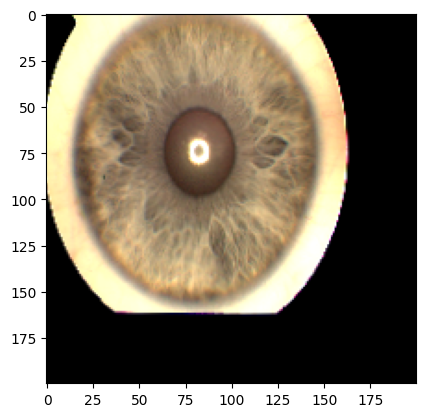

In [ ]:
plt.imshow(train_generator[1][0][2])
plt.show()

In [ ]:
image_shape = (IMG_HEIGHT, IMG_WIDTH, Channels)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=image_shape)
global_average_layer = GlobalAveragePooling2D()
prediction_layer1 = Dense(1024, activation='relu')
prediction_layer3 = Dense(2048, activation='relu')
prediction_layer2 = Dense(20, activation='softmax')

x = base_model.output
x = global_average_layer(x)
x = Dropout(0.2)(x)
x = prediction_layer1(x)
x = prediction_layer3(x)
outputs = prediction_layer2(x)
model = tf.keras.Model(inputs = base_model.inputs, outputs = outputs)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
learning_rate = 0.00001
epochs = 35

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

Epoch 1/35
90/90 [==============================] - 19s 144ms/step - loss: 3.0481 - accuracy: 0.0444 - val_loss: 2.9775 - val_accuracy: 0.1125
Epoch 2/35
90/90 [==============================] - 13s 142ms/step - loss: 2.9456 - accuracy: 0.0917 - val_loss: 2.7514 - val_accuracy: 0.2000
Epoch 3/35
90/90 [==============================] - 13s 139ms/step - loss: 2.6948 - accuracy: 0.0833 - val_loss: 2.4159 - val_accuracy: 0.2125
Epoch 4/35
90/90 [==============================] - 15s 164ms/step - loss: 2.4472 - accuracy: 0.1500 - val_loss: 1.9333 - val_accuracy: 0.3875
Epoch 5/35
90/90 [==============================] - 13s 140ms/step - loss: 2.0578 - accuracy: 0.2611 - val_loss: 1.6344 - val_accuracy: 0.4125
Epoch 6/35
90/90 [==============================] - 13s 139ms/step - loss: 1.6754 - accuracy: 0.3556 - val_loss: 1.2905 - val_accuracy: 0.5375
Epoch 7/35
90/90 [==============================] - 15s 163ms/step - loss: 1.3454 - accuracy: 0.5333 - val_loss: 1.0509 - val_accuracy: 0.6000

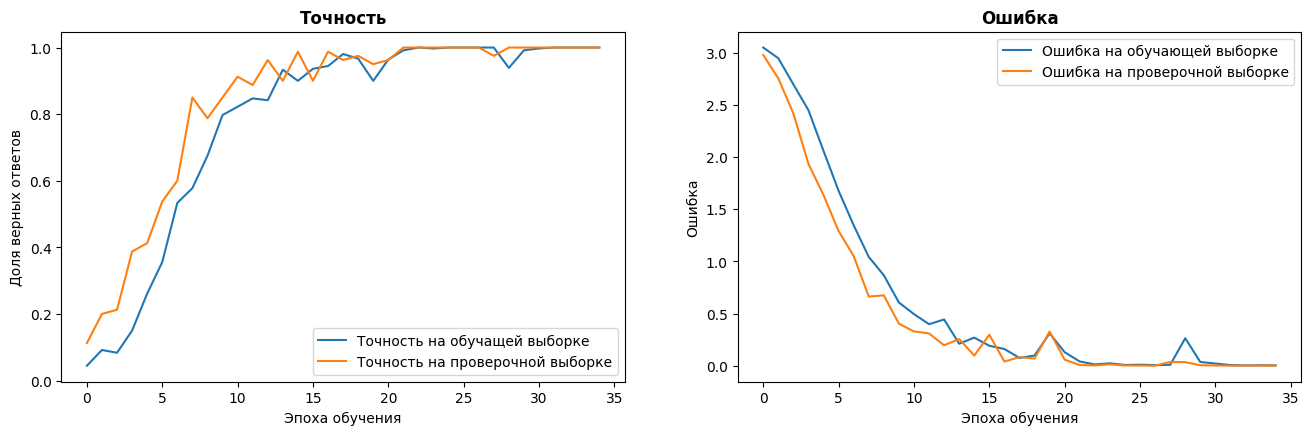

In [ ]:
History = model.fit(train_generator,
                    steps_per_epoch = train_generator.samples // batch_size,
                    validation_data=val_generator,
                    validation_steps = val_generator.samples // batch_size,
                    epochs=epochs,
                    verbose= 1)

plot_reault(History.history['accuracy'],
            History.history['val_accuracy'],
            History.history['loss'],
            History.history['val_loss'])

model.save_weights(f'/content/drive/MyDrive/model_weights.h5') 

In [ ]:
path_model = '/content/drive/MyDrive/model_weights.h5'
model.load_weights(path_model)

Ожидание 10L
1/1 [==============================] - 0s 443ms/step
Прдесказание 10L


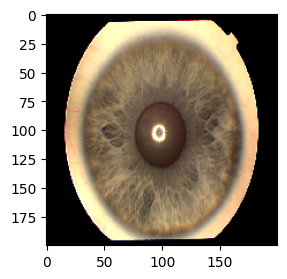

Ожидание 10R
1/1 [==============================] - 1s 816ms/step
Прдесказание 10R


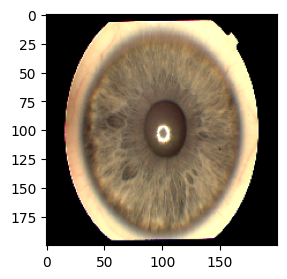

Ожидание 1L
1/1 [==============================] - 1s 796ms/step
Прдесказание 1R


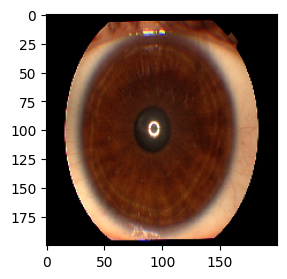

Ожидание 1R
1/1 [==============================] - 0s 451ms/step
Прдесказание 1R


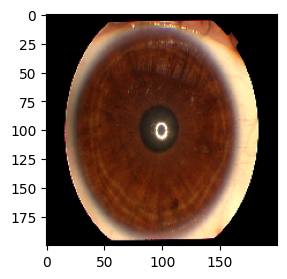

Ожидание 2L
1/1 [==============================] - 0s 441ms/step
Прдесказание 2L


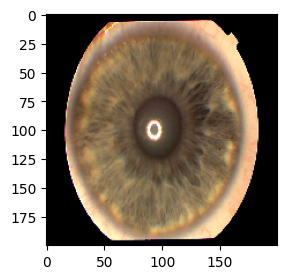

Ожидание 2R
1/1 [==============================] - 0s 430ms/step
Прдесказание 2R


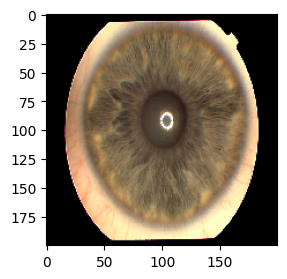

Ожидание 3L
1/1 [==============================] - 0s 451ms/step
Прдесказание 3R


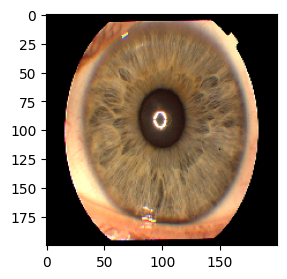

Ожидание 3R
1/1 [==============================] - 0s 449ms/step
Прдесказание 3R


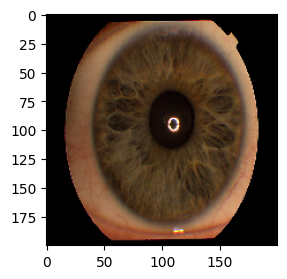

Ожидание 4L
1/1 [==============================] - 0s 447ms/step
Прдесказание 4L


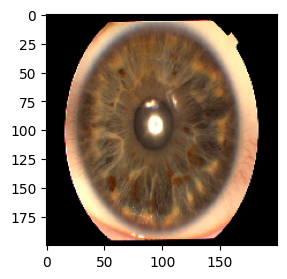

Ожидание 4R
1/1 [==============================] - 1s 677ms/step
Прдесказание 4R


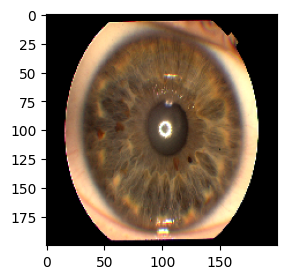

Ожидание 5L
1/1 [==============================] - 1s 846ms/step
Прдесказание 5L


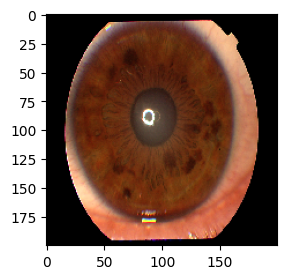

Ожидание 5R
1/1 [==============================] - 0s 439ms/step
Прдесказание 5R


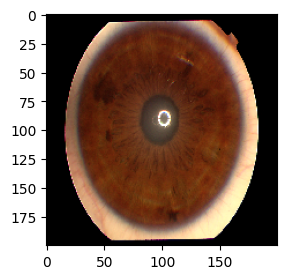

Ожидание 6L
1/1 [==============================] - 0s 459ms/step
Прдесказание 6L


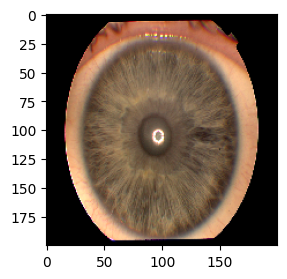

Ожидание 6R
1/1 [==============================] - 0s 429ms/step
Прдесказание 6R


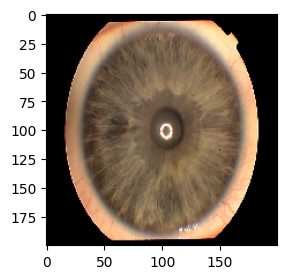

Ожидание 7L
1/1 [==============================] - 0s 447ms/step
Прдесказание 7L


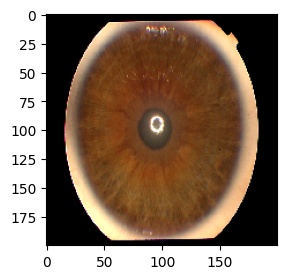

Ожидание 7R
1/1 [==============================] - 0s 431ms/step
Прдесказание 7L


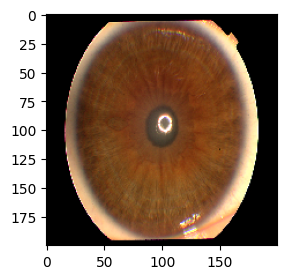

Ожидание 8L
1/1 [==============================] - 0s 437ms/step
Прдесказание 8R


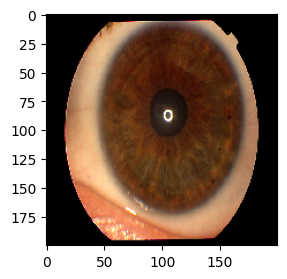

Ожидание 8R
1/1 [==============================] - 0s 436ms/step
Прдесказание 8R


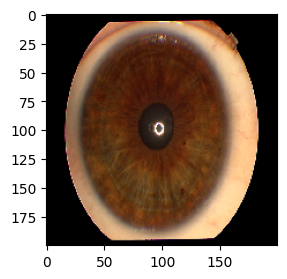

Ожидание 9L
1/1 [==============================] - 1s 810ms/step
Прдесказание 9L


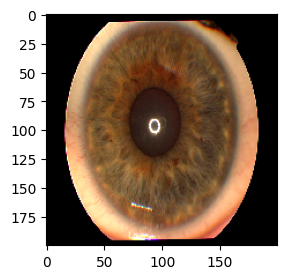

Ожидание 9R
1/1 [==============================] - 1s 812ms/step
Прдесказание 9L


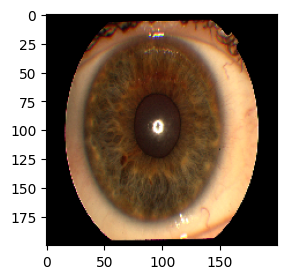

In [ ]:
for i in range(20):
    plt.figure(figsize = (3,3))    
    print(f'Ожидание {Class_name[np.argmax(test_generator[0][1][i])]}')    
    img_np = np.array([test_generator[0][0][i]]) 
    prediction = model.predict(img_np)
    print(f'Прдесказание {Class_name[np.argmax(prediction)]}')
    plt.imshow(test_generator[0][0][i])
    plt.show()